In [1]:
import bruges
import numpy as np
import matplotlib.pyplot as plt
import math

# celluloid for easier matplotlib animations
from IPython.display import HTML
from celluloid import Camera

To do:

- figure out if I need to pad everything so it's centered at zero

In [2]:
DURATION=0.5
DT=0.01
CENTER_FREQ=16

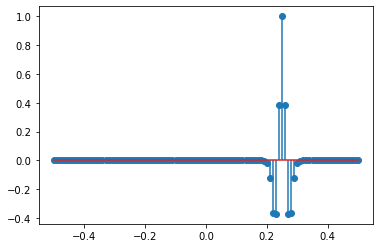

In [3]:
rickerin, times = bruges.filters.wavelets.ricker(duration=DURATION, dt=DT, f=CENTER_FREQ, return_t=True)

# shift amplitudes to positive times and pad the negative times
rickerin = np.hstack([0*times[1:], rickerin])
# shift so first sample is at time zero
times += -1*times[0]
# zero pad the time axis
times = np.hstack([-1*times[:0:-1], times])

plt.stem(times, rickerin, use_line_collection=True)
plt.show()

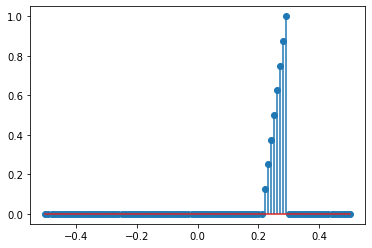

In [4]:
ramp = np.pad(np.ones(1),[8,0], mode="linear_ramp")
ramp = np.pad(ramp,[71,21])
plt.stem(times, ramp, use_line_collection=True)
plt.show()

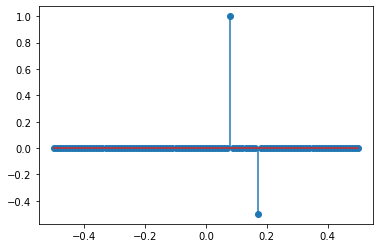

In [5]:
twospikes = np.hstack((np.pad(np.ones(1),[58,4]),-0.5*np.pad(np.ones(1),[4,33])))
plt.stem(times, twospikes, use_line_collection=True)
plt.show()

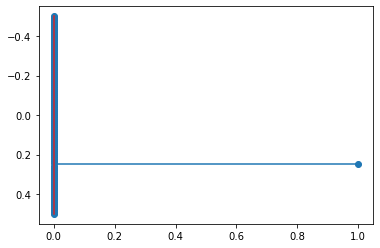

In [6]:
# spike_a = np.hstack((np.pad(np.ones(1),2),np.pad(np.ones(1),[7])))
spike_b = np.pad(np.ones(1),[75,25])
plt.stem(times, spike_b, use_line_collection=True, orientation="horizontal")
ax = plt.gca(); ax.invert_yaxis()
plt.show()

In [7]:
def td_kernel_mult(trace_a, trace_b, times):
    '''
    for two traces, return three generators:
    0: steps of the kernel being multiplied
    1: zero-padded result of multiplying this kernel and summing
    2: running sum of these results, which will become the convolution result
    '''
    assert len(trace_a.shape) == 1
    assert len(trace_a.shape) == 1
    
    if trace_a.shape[0] <= trace_b.shape[0]:
        a = trace_a
        b = trace_b[::-1]
    else:
        a = trace_b
        b = trace_a[::-1]
    
    steps = b.shape[0]

    # output starts as blank
    result = np.zeros(steps)
    kernel_halfwidth = math.ceil(steps/2)
    kernel = np.pad(b, kernel_halfwidth)
    
    for i in range(steps):
        kernel_step = kernel[steps-i:2*steps-i]
        step_mult = a*kernel_step
        step_add = np.pad([np.sum(step_mult)],(i,steps-i-1))
        result += step_add
        yield kernel_step, step_mult, step_add, result

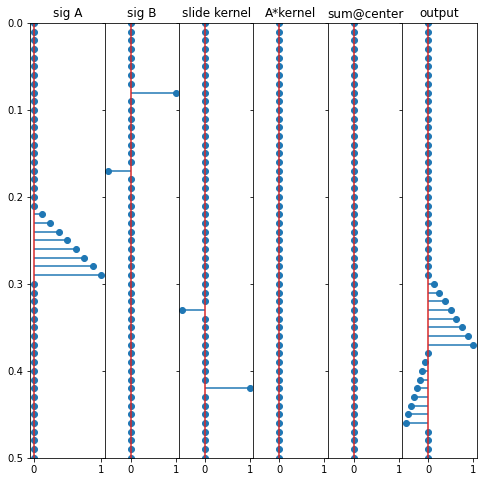

In [9]:
# We'll use celluloid to make the movie
fig = plt.figure(figsize=(8,8))
fig.patch.set_alpha(1.)
gs = fig.add_gridspec(1, 6, wspace=0)
axes = gs.subplots(sharey=True,)
# axes.set_ylim(max(times),min(times))
camera = Camera(fig)
[a.set_ylim(max(times),0) for a in axes]

titles = ["sig A", "sig B", "slide kernel", "A*kernel", "sum@center", "output"]
[axes[i].set_title(t) for i, t in enumerate(titles)]

time_iter = iter(times)

for out in td_kernel_mult(ramp, twospikes, times):
    t = next(time_iter)
    if t < 0: continue
    else:
        axes[0].stem(times, ramp, use_line_collection=True, orientation="horizontal")
        axes[1].stem(times, twospikes, use_line_collection=True, orientation="horizontal")
        axes[2].stem(times, out[0], use_line_collection=True, orientation="horizontal")
        axes[3].stem(times, out[1], use_line_collection=True, orientation="horizontal")
        axes[4].stem(times, out[2], use_line_collection=True, orientation="horizontal")
        axes[5].stem(times, out[3], use_line_collection=True, orientation="horizontal")
    camera.snap();
animation = camera.animate()
HTML(animation.to_html5_video())
# animation.save("2022-02-17_ramp_two-spikes_convolution.mp4", dpi=100, bitrate=-1)
animation.save("2022-02-17_ramp_two-spikes_convolution.gif")